# **Распознование жестов (5 жестов)**

# **Распознование на основе  модели ResNet50, кастомная модель .**

Импорт необходимых библиотек

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.transforms as tt
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
import cv2
from PIL import Image

from pathlib import Path

In [ ]:
Локализация необходимых папок

In [2]:
DATA_ROOT = Path('gesture_250302024')

In [ ]:
5 классов в датасете

In [3]:
tmp_ds = ImageFolder(DATA_ROOT)
CLASSES_NAME = tmp_ds.classes
CLASSES_NAME

['L', 'OK', 'first', 'palm', 'peace']

In [51]:
import cv2
import os
from pathlib import Path


source_dir = Path('gesture_250302024/peace')


for img_path in source_dir.glob('*.png'):  
    #чтение изображения
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #  Canny edge детектор
    edges = cv2.Canny(image=img_rgb, threshold1=100, threshold2=700)
    
    
    save_path_edges = img_path.parent / f'{img_path.stem}.png'
    
    
    cv2.imwrite(str(save_path_edges), edges)

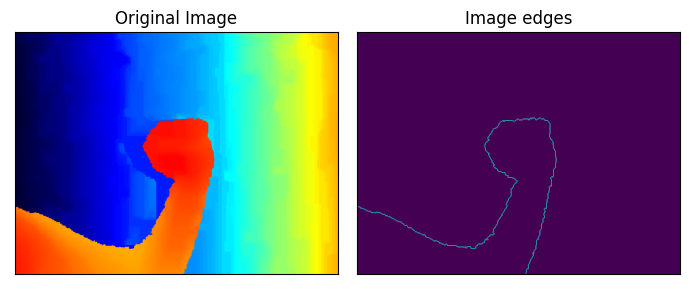

In [45]:
#тест
import cv2
import numpy as np
import matplotlib.pyplot as plt
  
# Read image from disk.
img = cv2.imread('first/125.png')
# Convert BGR image to RGB
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 
# Apply Canny edge detection
edges = cv2.Canny(image= image_rgb, threshold1=100, threshold2=700)
 
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(7, 4))
 
# Plot the original image
axs[0].imshow(image_rgb)
axs[0].set_title('Original Image')
 
# Plot the blurred image
axs[1].imshow(edges)
axs[1].set_title('Image edges')
 
# Remove ticks from the subplots
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
 
# Display the subplots
plt.tight_layout()
plt.show()

In [4]:
train_tfms = tt.Compose([
                         tt.Grayscale(num_output_channels=3), # Pictures black and white
                         tt.Resize([128, 128]),
                         # Settings for expanding the dataset
                         tt.RandomHorizontalFlip(),           # Random 90 degree rotations
                         tt.RandomRotation(30),               # Random 30 degree rotations
                         tt.ToTensor(),                      # Cast to tensor
                         ])                      

test_tfms = tt.Compose([
                        tt.Grayscale(num_output_channels=3),
                        tt.Resize([128, 128]),
                        tt.ToTensor(),
                        ])
     

In [61]:
from PIL import Image
import os
import torchvision.transforms.functional as TF

# Adjusted transforms without ToTensor()
train_tfms_save = tt.Compose([
    tt.Grayscale(num_output_channels=3),
    tt.Resize([128, 128]),
    tt.RandomHorizontalFlip(),
    tt.RandomRotation(30),
])

test_tfms_save = tt.Compose([
    tt.Grayscale(num_output_channels=3),
    tt.Resize([128, 128]),
])

def save_transformed_images(tmp_ds, transform, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for i, (image, label) in enumerate(tmp_ds):
        # Apply the transformation
        transformed_image = transform(image)

        # Save the image
        save_path = os.path.join(save_dir, f"{label}_{i}.png")
        transformed_image.save(save_path)


train_save_path = 'datasets/train'
test_save_path = 'datasets/test'


save_transformed_images(tmp_ds, train_tfms_save, train_save_path)
save_transformed_images(tmp_ds, test_tfms_save, test_save_path)


In [67]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as tt
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import numpy as np


DATA_ROOT = 'gesture_250302024'
CLASSES_NAME = ['L', 'OK', 'first', 'palm', 'peace']

# Load the dataset
tmp_ds = ImageFolder(DATA_ROOT)


train_tfms_save = tt.Compose([
    tt.Grayscale(num_output_channels=3),
    tt.Resize([128, 128]),
    tt.RandomHorizontalFlip(),
    tt.RandomRotation(30),
   
])

test_tfms_save = tt.Compose([
    tt.Grayscale(num_output_channels=3),
    tt.Resize([128, 128]),
    
])

def save_transformed_images(dataset, indices, transform, save_dir_base):
    for idx in indices:
        image, label = dataset[idx]
       
        transformed_image = transform(image)

        
        class_name = CLASSES_NAME[label]
        save_dir = os.path.join(save_dir_base, class_name)
        os.makedirs(save_dir, exist_ok=True)

       
        save_path = os.path.join(save_dir, f"img_{idx}.png")
        transformed_image.save(save_path)


indices = np.arange(len(tmp_ds))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)


train_save_path = 'datasets/train'
test_save_path = 'datasets/test'


save_transformed_images(tmp_ds, train_indices, train_tfms_save, train_save_path)
save_transformed_images(tmp_ds, test_indices, test_tfms_save, test_save_path)


In [1]:
import os
import glob
import zipfile
import seaborn as sb
import numpy as np # linear algebra
import pandas as pd # data processing 
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Model,Sequential
from keras.layers import Conv2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from sklearn.metrics import confusion_matrix,classification_report
from keras.optimizers import Adam

In [8]:
def prepare_data(dir_path):
    filenames = os.listdir(dir_path)
    labels = []
    for filename in filenames:
        label = filename.split('.')[0]
        if label == 'dog':
            labels.append(1)
        else:
            labels.append(0)
    return filenames,labels


train_filenames,train_labels = prepare_data('datasets/train') 
test_filenames,test_labels = prepare_data('datasets/test') 

df_train = pd.DataFrame({'filename':train_filenames})
df_test = pd.DataFrame({'filename': test_filenames})

In [9]:
df_train.head()

,filename
0,first
1,L
2,OK
3,palm
4,peace


In [10]:
df_test.head()

,filename
0,first
1,L
2,OK
3,palm
4,peace


In [76]:

cats = df_train[df_train['class']==0][:3000]
dogs = df_train[df_train['class']==1][:3000]
#concat the two dataframes
df = pd.concat([cats,dogs])
#shuffle
df = df.sample(frac=1)
df.shape

(5, 2)

In [5]:
train_ds_list = []
test_ds_list = []
for dir in os.listdir(DATA_ROOT):
    train_ds = ImageFolder(os.path.join(DATA_ROOT), train_tfms)
    test_ds = ImageFolder(os.path.join(DATA_ROOT), test_tfms)
    train_ds_list.append(train_ds)
    test_ds_list.append(test_ds)

train_ds = ConcatDataset(train_ds_list)
test_ds = ConcatDataset(test_ds_list)

In [6]:
LEN_DS = len(train_ds)
LEN_DS

5000

**The function to convert the class number to its name:**

In [7]:
def digit_to_classname(digit):
    for idx, itm in enumerate(CLASSES_NAME):
        if idx == digit:
            return itm

Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000})


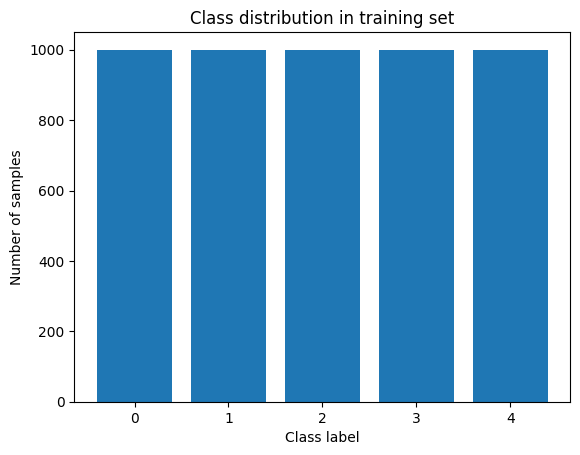

In [8]:
from collections import Counter

train_counts = Counter([label for _, label in train_ds])
print(train_counts)

import matplotlib.pyplot as plt
plt.bar(train_counts.keys(), train_counts.values())
plt.xlabel('Class label')
plt.ylabel('Number of samples')
plt.title('Class distribution in training set')
plt.show()

**Сбалансировано по количеству.**

In [9]:
torch.manual_seed(1)

val_split = 0.2
split = int(LEN_DS * val_split)
indices = torch.randperm(LEN_DS)

train_ds = torch.utils.data.Subset(train_ds, indices[split:])
test_ds = torch.utils.data.Subset(test_ds, indices[:split])

len(train_ds), len(test_ds)

(4000, 1000)

In [10]:
train_ds[3000][0].size()

torch.Size([3, 128, 128])

In [11]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2)
test_dl = DataLoader(test_ds, batch_size, num_workers=1, shuffle=False)

torch.Size([3, 128, 128])
tensor(2) first


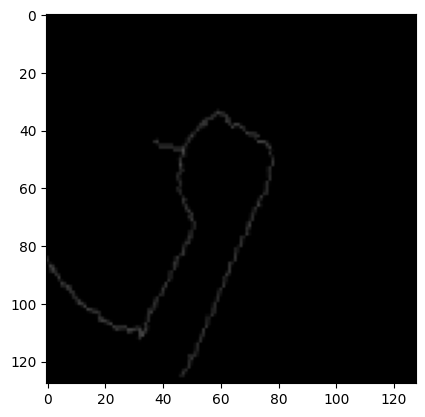

In [12]:
for img, l in train_dl:
    print(img[0].shape)
    print(l[0], digit_to_classname(l[0]))
    plt.imshow(img[0].permute(1, 2, 0)) #, cmap='gray')
    break

In [13]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([3, 128, 128])


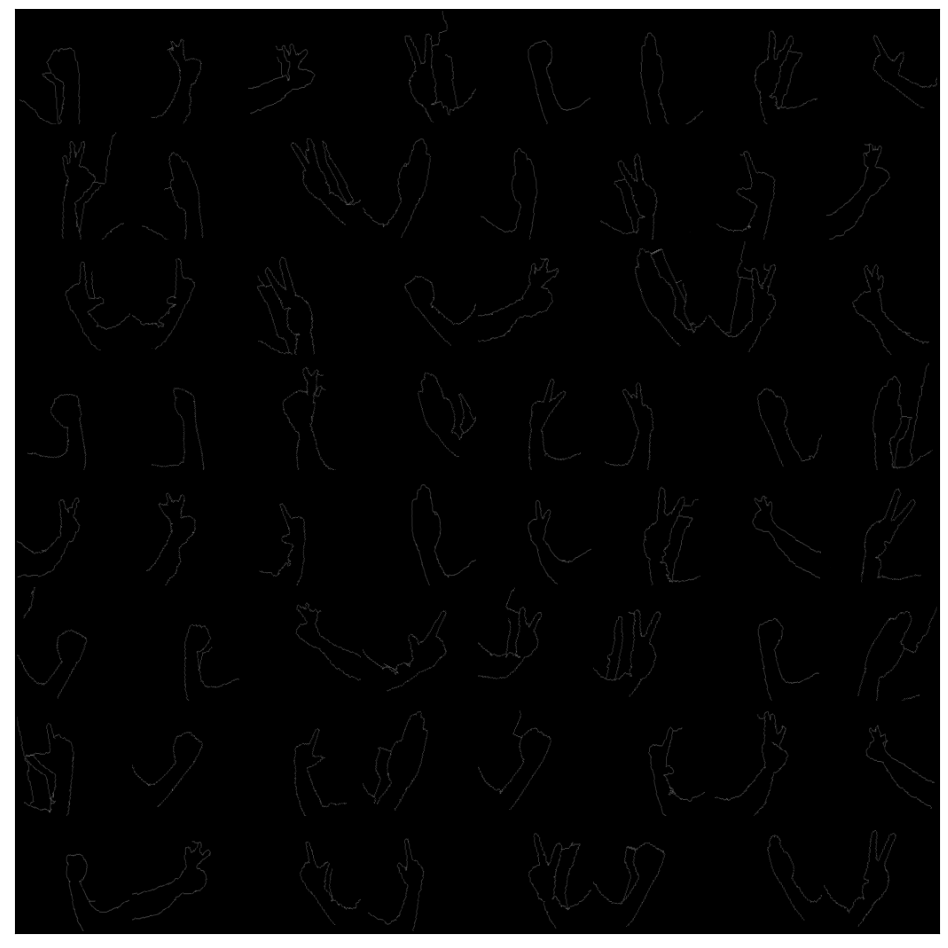

In [14]:
show_batch(train_dl)

In [15]:
import torch
torch.cuda.is_available()

False

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

**Загружаем веса тренированной сети resnet50 **

In [17]:
resnet = models.resnet50(pretrained=True)
summary(resnet.to(device), input_size=(3, 128, 128))

C:\Users\Adel\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Adel\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

In [18]:
for param in resnet.parameters():
    param.requires_grad = False

In [19]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
in_features = resnet.fc.in_features
fc = nn.Linear(in_features=in_features, out_features=len(CLASSES_NAME))
resnet.fc = fc

summary(resnet.to(device), input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

In [21]:
params_to_update = []
for name, param in resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

        
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params_to_update, lr=0.001)


In [22]:
from time import time

def train(model,
          criterion,
          optimizer,
          train_dataloader,
          test_dataloader,
          print_every,
          num_epoch):
    steps = 0
    train_losses, val_losses = [], []

    model.to(device)
    for epoch in range(num_epoch):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()
        
        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = model(images)
            loss = criterion(output, labels)

            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Logging
            if steps % print_every == 0:
                print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
                print(f'Train loss {running_loss / steps:.3f}.', end=' ')
                print(f'Train acc {correct_train / total_train * 100:.3f}.', end=' ')
                with torch.no_grad():
                    model.eval()
                    correct_val, total_val = 0, 0
                    val_loss = 0
                    for images, labels in test_dataloader:
                        images = images.to(device)
                        labels = labels.to(device)
                        output = model(images)
                        loss = criterion(output, labels)
                        val_loss += loss.item()

                        correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                        total_val += labels.size(0)

                print(f'Val loss {val_loss / len(test_dataloader):.3f}. Val acc {correct_val / total_val * 100:.3f}.', end=' ')
                print(f'Took {time() - iter_time:.3f} seconds')
                iter_time = time()

                train_losses.append(running_loss / total_train)
                val_losses.append(val_loss / total_val)


        print(f'Epoch took {time() - start_time}') 
        torch.save(model, f'checkpoint_{correct_val / total_val * 100:.2f}')
        
    return model, train_losses, val_losses

**10 эпох**

In [23]:
print_every = 50
num_epoch = 20

resnet, train_losses, val_losses = train(
    model=resnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dl,
    test_dataloader=test_dl,
    print_every=print_every,
    num_epoch=num_epoch
)

Epoch [1]/[20]. Batch [50]/[63]. Train loss 0.883. Train acc 70.469. Val loss 1.459. Val acc 27.500. Took 101.096 seconds
Epoch took 118.29082202911377
Epoch [2]/[20]. Batch [37]/[63]. Train loss 0.182. Train acc 83.277. Val loss 0.559. Val acc 80.700. Took 82.648 seconds
Epoch took 115.7730040550232
Epoch [3]/[20]. Batch [24]/[63]. Train loss 0.071. Train acc 85.742. Val loss 0.580. Val acc 77.700. Took 63.315 seconds
Epoch took 113.28883671760559
Epoch [4]/[20]. Batch [11]/[63]. Train loss 0.020. Train acc 87.358. Val loss 0.445. Val acc 83.800. Took 43.090 seconds
Epoch [4]/[20]. Batch [61]/[63]. Train loss 0.084. Train acc 88.883. Val loss 0.483. Val acc 81.100. Took 91.525 seconds
Epoch took 136.90852546691895
Epoch [5]/[20]. Batch [48]/[63]. Train loss 0.053. Train acc 89.681. Val loss 0.358. Val acc 87.400. Took 104.730 seconds
Epoch took 126.25164365768433
Epoch [6]/[20]. Batch [35]/[63]. Train loss 0.033. Train acc 88.125. Val loss 0.354. Val acc 86.000. Took 80.812 seconds
Ep

**If you need to train the model, you can train the neural network for one more epoch:**

In [38]:
resnet, train_losses, val_losses = train(
    model=resnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dl,
    test_dataloader=test_dl,
    print_every=print_every,
    num_epoch=1
)

Epoch [1]/[1]. Batch [50]/[63]. Train loss 0.377. Train acc 87.594. Val loss 0.329. Val acc 88.200. Took 108.318 seconds
Epoch took 125.5653293132782


In [39]:
#print_every = 50
num_epoch = 20

resnet, train_losses, val_losses = train(
    model=resnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dl,
    test_dataloader=test_dl,
    print_every=print_every,
    num_epoch=num_epoch
)

Epoch [1]/[20]. Batch [50]/[63]. Train loss 0.410. Train acc 85.219. Val loss 0.371. Val acc 86.200. Took 102.766 seconds
Epoch took 118.66330432891846
Epoch [2]/[20]. Batch [37]/[63]. Train loss 0.155. Train acc 85.220. Val loss 0.325. Val acc 89.200. Took 77.373 seconds
Epoch took 109.5620608329773
Epoch [3]/[20]. Batch [24]/[63]. Train loss 0.069. Train acc 84.701. Val loss 0.370. Val acc 87.400. Took 60.878 seconds
Epoch took 109.68633651733398
Epoch [4]/[20]. Batch [11]/[63]. Train loss 0.022. Train acc 86.648. Val loss 0.352. Val acc 86.200. Took 41.969 seconds
Epoch [4]/[20]. Batch [61]/[63]. Train loss 0.087. Train acc 87.935. Val loss 0.315. Val acc 88.200. Took 84.753 seconds
Epoch took 128.97336554527283
Epoch [5]/[20]. Batch [48]/[63]. Train loss 0.061. Train acc 87.598. Val loss 0.311. Val acc 89.000. Took 109.853 seconds
Epoch took 129.15091276168823
Epoch [6]/[20]. Batch [35]/[63]. Train loss 0.037. Train acc 87.679. Val loss 0.329. Val acc 88.200. Took 85.504 seconds
Ep

**Save and download our model:**

In [24]:
torch.save(resnet, 'ResNet50_hand_25032024_edge.h5')

In [25]:
resnet = torch.load('ResNet50_hand_25032024_edge.h5')
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [35]:
torch.save(resnet, 'ResNet50_hand_25032024_edge.pt')


In [32]:
torch.save(resnet.state_dict(), 'ResNet50_hand_25032024_edge_state_dict.pt')


In [45]:
#model = torch.load('ResNet50_hand_25032024_edge.pt')
model.eval() 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

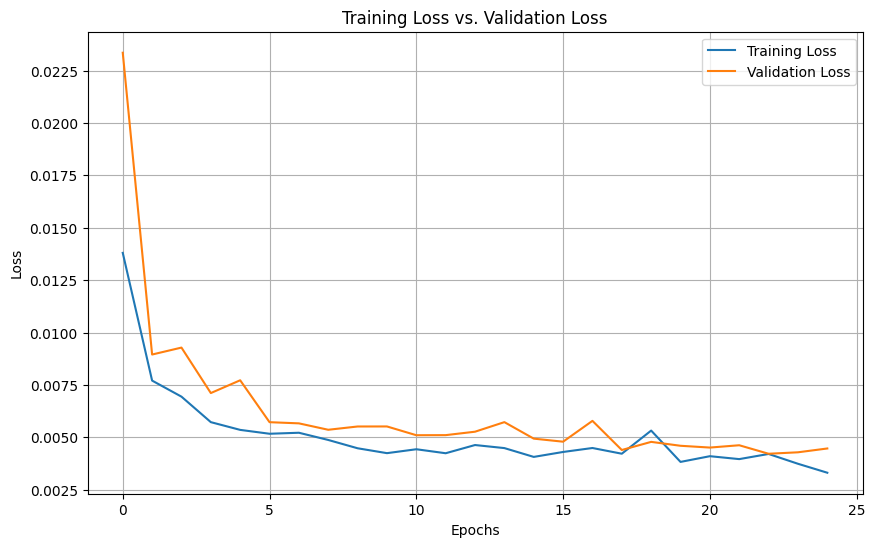

In [47]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training Loss vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


**тест 5 рандомных изображений**

In [ ]:
with torch.no_grad():
    for i, data in enumerate(test_dl, 3):
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs = resnet(images)
        plt.title(f'pred - {digit_to_classname(outputs[0].argmax())}, gt - {digit_to_classname(labels[0])}')
        plt.imshow(images[0].cpu().permute(1, 2, 0), cmap='gray')
        plt.show()
        if i>5:
            break

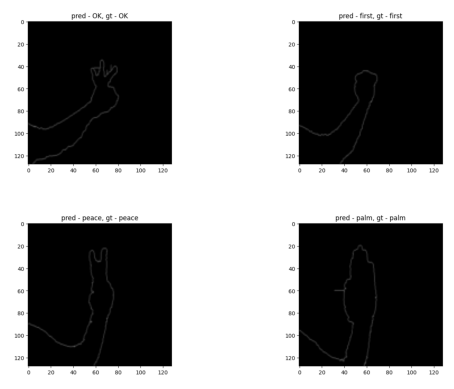

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the images
image = mpimg.imread("123.png")
image1 = mpimg.imread("1234.png")
image2 = mpimg.imread("12345.png")
image3 = mpimg.imread("123456.png")

# Create a figure to host the subplots
fig, axs = plt.subplots(2, 2)  # This creates a 2x2 grid of subplots

# Display each image in its respective subplot
axs[0, 0].imshow(image)
axs[0, 0].axis('off')  # Turn off axis to only show the image

axs[0, 1].imshow(image1)
axs[0, 1].axis('off')

axs[1, 0].imshow(image2)
axs[1, 0].axis('off')

axs[1, 1].imshow(image3)
axs[1, 1].axis('off')

plt.show()  # Display the figure with the images
